In [1]:
%matplotlib inline
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
timer = d2l.Timer()
A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)

In [3]:
# 逐元素计算A=BC
timer.start()
for i in range(256):
    for j in range(256):
        A[i, j] = torch.dot(B[i, :], C[:, j])
timer.stop()

0.44766855239868164

In [4]:
# 更快的策略是执行按列分配
timer.start()
for j in range(256):
    A[:, j] = torch.mv(B, C[:, j])
timer.stop()

0.0041806697845458984

In [7]:
# 最有效的方法是在一个去快中执行整个操作，让我们看看他们各自的操作速度是多少
# 一次性计算A=BC
timer.start()
A = torch.mm(B, C)
timer.stop()

# 乘法和假发作为单独的操作（在实践中融合）
gigaflops = [2/i for i in timer.times]
print(f'performance in Gigaflops: element {gigaflops[0]:.3f},'
      f'column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}')

performance in Gigaflops: element 4.468,column 478.392, full 0.026


In [8]:
timer.start()
for j in range(0, 256, 64):
    A[:, j:j+64] = torch.mm(B, C[:, j:j+64])
timer.stop()
print(f'performance in Gigaflops: block {2 / timer.times[3]:.3f}')


performance in Gigaflops: block 4256.016


In [9]:
#@save
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

#@save
def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1


In [10]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr']*p.grad)
        p.grad.data.zero_()

In [13]:
from IPython import display
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None, ylim=None, xscale='linear', yscale='linear', fmts=('-', 'm--', 'g-', 'r:'), nrows=1, ncols=1, figsize=(3.5, 2.5)):
        if legend is None:
            legend=[]
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, nrows, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        self.config_axes = lambda: d2l.set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts=None, None, fmts

    def add(self, x, y):
        if not hasattr(y, '__len__'):
            y = [y]
        n = len(y)
        if not hasattr(x, '__len__'):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            self.X[i].append(a)
            self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        print(self.X[0])
        display.display(self.fig)
        display.clear_output(wait=True)

class Accumulator:
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(bool) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1]>1:
        y_hat = d2l.argmax(y_hat, axis=1)
    cmp = d2l.astype(y_hat, y.dtype) == y
    return float(d2l.reduce_sum(d2l.astype(cmp, y.dtype)))

def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()
    metrics = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metrics.add(accuracy(net(X), y), d2l.size(y))
    return metrics[0]/metrics[1]

def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = d2l.reshape(y, out.shape)
        l = loss(out, y)
        metric.add(d2l.reduce_sum(l), d2l.size(l))
    return metric[0] / metric[1]
def train_ch11(trainer_fn, states, hyperparams, data_iter, feature_dim, num_epochs=2):
    # 初始化模型
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1), requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # 训练模型
    animator = Animator(xlabel='epoch', ylabel='loss', xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n%200==0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),(evaluate_loss(net, data_iter, loss), ))
                timer.start()
    print(f'loss:{animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

loss:0.256, 0.019 sec/epoch


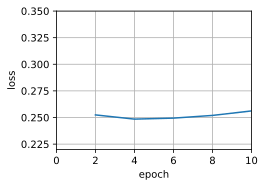

In [14]:
# 让我们看看批量梯度下降的优化是如何进行的。这可以通过将小批量设置为1500（即样本总数）来实现，因此，模型参数每个迭代轮数只迭代一次。
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

gd_res = train_sgd(1, 1500, 10)

loss:0.244, 0.020 sec/epoch


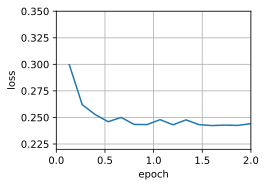

In [22]:
# 当批量大小为1时，优化使用的是随机梯度下降。为了简化实现，我们选择了很小的学习率，在随机梯度下降的实验中，每当一个样本被处理，模型参数都会被更新。可以看到，目标函数值的下降在1个迭代轮数后就变得较为平缓，尽管两个列子在一个迭代轮数内都处理了1500个样本，但实验中随机梯度下降的一个迭代轮数耗时更多。这是因为随机梯度下降更频繁地更新了参数，而且一次处理单个观测值效率较低。
sgd_res = train_sgd(0.005, 1)

loss:0.242, 0.001 sec/epoch


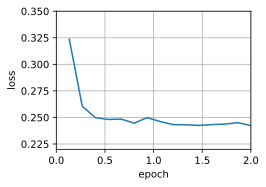

In [23]:
# 最后，当批量大小等于100时，我们使用小批量随机梯度下降进行优化，每个迭代轮数所需的时间比随机梯度下降和批量梯度下降所需的时间短。
minil_res = train_sgd(.4, 100)

loss:0.242, 0.004 sec/epoch


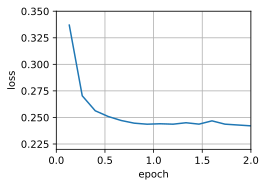

In [33]:
minil2_res = train_sgd(.04, 10)

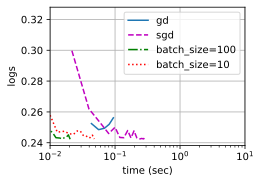

In [30]:
# 现在我们可以比较前四个实验的时间与损失，可以看出，尽管在处理的样本数方面，随机梯度下降的收敛速度快与梯西江，但与梯度下降相比，它需要更多的时间来达到同样的损失，因为逐个样本来计算梯度并不那么有效。小批量随机梯度下降能够平衡收敛和计算效率。大小为10的小批量比随机梯度下降更有效;大小为 100的小批量在运行时间上甚至优于梯度下降
d2l.set_figsize([6, 31])
d2l.plot(*list(map(list, zip(gd_res, sgd_res, minil_res, minil2_res))), 'time (sec)', 'logs', xlim=[1e-2, 10], legend=['gd', 'sgd', 'batch_size=100', 'batch_size=10'])
d2l.plt.gca().set_xscale('log')

In [28]:
# 简洁实现
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # 初始化模型
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none')
    animator = Animator(xlabel='epoch', ylabel='loss', xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                # MSELoss计算平方误差时不带系数1/2
                animator.add(n/X.shape[0]/len(data_iter), (evaluate_loss(net, data_iter, loss)/2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')


loss: 0.471, 0.003 sec/epoch


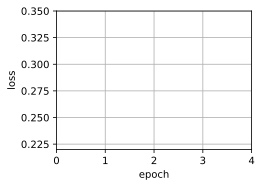

In [35]:
data_iter, _ = get_data_ch11(20)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.01}, data_iter)